![](../../img/chinahadoop.png)

# xgboost用法速查表


## 内置建模方式
- xgb.train训练方式
- DMatrix数据形态，不是DataFrame

### 读取libsvm格式数据并指定参数建模

In [15]:
#!/usr/bin/python
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb

# 基本例子，从libsvm文件中读取数据，做二分类
# 数据是libsvm的格式
#1 3:1 10:1 11:1 21:1 30:1 34:1 36:1 40:1 41:1 53:1 58:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 105:1 117:1 124:1
#0 3:1 10:1 20:1 21:1 23:1 34:1 36:1 39:1 41:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 106:1 116:1 120:1
#0 1:1 10:1 19:1 21:1 24:1 34:1 36:1 39:1 42:1 53:1 56:1 65:1 69:1 77:1 86:1 88:1 92:1 95:1 102:1 106:1 116:1 122:1
dtrain = xgb.DMatrix('./data/agaricus.txt.train')
dtest = xgb.DMatrix('./data/agaricus.txt.test')

#超参数设定
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 2
bst = xgb.train(param, dtrain, num_round, watchlist)

# 使用模型预测
preds = bst.predict(dtest)

# 判断准确率
labels = dtest.get_label()
print('错误率为%f' % \
       (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# 模型存储
bst.save_model('./model/0001.model')

[0]	eval-error:0.042831	train-error:0.046522
[1]	eval-error:0.021726	train-error:0.022263
错误率为0.021726


### 配合pandas DataFrame格式数据建模

In [2]:
# 皮马印第安人糖尿病数据集 包含很多字段：怀孕次数 口服葡萄糖耐量试验中血浆葡萄糖浓度 舒张压（mm Hg） 三头肌组织褶厚度（mm） 
# 2小时血清胰岛素（μU/ ml） 体重指数（kg/（身高(m)^2） 糖尿病系统功能 年龄（岁）
import pandas as pd
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 转换成Dmatrix格式
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
# 取出numpy array去初始化DMatrix对象
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

#参数设定
param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 10
bst = xgb.train(param, xgtrain, num_round, watchlist)

# 使用模型预测
preds = bst.predict(xgtest)

# 判断准确率
labels = xgtest.get_label()
print('错误类为%f' % \
       (sum(1 for i in range(len(preds)) if int(preds[i]>0.5)!=labels[i]) /float(len(preds))))

# 模型存储
bst.save_model('./model/0002.model')

[0]	eval-error:0.296875	train-error:0.182292
[1]	eval-error:0.296875	train-error:0.168403
[2]	eval-error:0.286458	train-error:0.171875
[3]	eval-error:0.265625	train-error:0.159722
[4]	eval-error:0.260417	train-error:0.147569
[5]	eval-error:0.255208	train-error:0.133681
[6]	eval-error:0.265625	train-error:0.137153
[7]	eval-error:0.270833	train-error:0.126736
[8]	eval-error:0.28125	train-error:0.130208
[9]	eval-error:0.276042	train-error:0.133681


TypeError: 'type' object is not subscriptable

## 预估器建模方式(sklearn形态)

In [2]:
#!/usr/bin/python
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 取出特征X和目标y的部分
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
train_X = train[feature_columns].values
train_y = train[target_column].values
test_X = test[feature_columns].values
test_y = test[target_column].values

# 初始化模型
xgb_classifier = xgb.XGBClassifier(n_estimators=20,\
                                   max_depth=4, \
                                   learning_rate=0.1, \
                                   subsample=0.7, \
                                   colsample_bytree=0.7)

# 拟合模型
xgb_classifier.fit(train_X, train_y)

# 使用模型预测
preds = xgb_classifier.predict(test_X)

# 判断准确率
print('错误类为%f' %((preds!=test_y).sum()/float(test_y.shape[0])))

# 模型存储
joblib.dump(xgb_classifier, './model/0003.model')

NameError: name 'xgtest' is not defined

## 内置建模方式：交叉验证与高级功能

### 交叉验证

In [5]:
xgb.cv(param, dtrain, num_round, nfold=5,metrics={'error'}, seed = 0)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.008329,0.004488,0.009829,0.005859
1,0.003838,0.001788,0.005067,0.001857
2,0.003263,0.001780,0.004606,0.003534
3,0.001881,0.001397,0.002456,0.003123
4,0.001574,0.000809,0.001842,0.001977
5,0.001305,0.000372,0.001382,0.001228
6,0.001228,0.000260,0.001228,0.001041
7,0.001228,0.000260,0.001228,0.001041
8,0.001228,0.000260,0.001228,0.001041
9,0.001228,0.000260,0.001228,0.001041


### 添加预处理的交叉验证

In [6]:
# 计算正负样本比，调整样本权重
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label==1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

# 先做预处理，计算样本权重，再做交叉验证
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'auc'}, seed = 0, fpreproc = fpreproc)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.995562,0.001265,0.994036,0.001449
1,0.999546,0.000749,0.999860,0.000121
2,0.999764,0.000372,0.999900,0.000113
3,0.999774,0.000378,0.999930,0.000116
4,0.999969,0.000037,0.999903,0.000160
5,0.999987,0.000012,0.999955,0.000058
6,0.999991,0.000006,0.999978,0.000020
7,0.999994,0.000006,0.999977,0.000021
8,0.999996,0.000004,0.999980,0.000022
9,0.999997,0.000004,0.999987,0.000019


### 自定义损失函数与评估准则

In [7]:
print('使用自定义损失函数进行交叉验证')
# 自定义损失函数，需要提供损失函数的一阶导和二阶导
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0-preds)
    return grad, hess

# 自定义评估准则，评估预估值和标准答案之间的差距
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

watchlist  = [(dtest,'eval'), (dtrain,'train')]
param = {'max_depth':3, 'eta':0.1, 'silent':1}
num_round = 5
# 自定义损失函数训练
bst = xgb.train(param, dtrain, num_round, watchlist, logregobj, evalerror)
# 交叉验证
xgb.cv(param, dtrain, num_round, nfold = 5, seed = 0,
       obj = logregobj, feval=evalerror)

使用自定义损失函数进行交叉验证
[0]	eval-rmse:0.306901	train-rmse:0.306164	eval-error:0.518312	train-error:0.517887
[1]	eval-rmse:0.179189	train-rmse:0.177278	eval-error:0.518312	train-error:0.517887
[2]	eval-rmse:0.172565	train-rmse:0.171728	eval-error:0.016139	train-error:0.014433
[3]	eval-rmse:0.269612	train-rmse:0.27111	eval-error:0.016139	train-error:0.014433
[4]	eval-rmse:0.396903	train-rmse:0.398256	eval-error:0.016139	train-error:0.014433


,train-error-mean,train-error-std,train-rmse-mean,train-rmse-std,test-error-mean,test-error-std,test-rmse-mean,test-rmse-std
0,0.517887,0.001085,0.308875,0.005171,0.517886,0.004343,0.309039,0.005206
1,0.517887,0.001085,0.176503,0.002046,0.517886,0.004343,0.177803,0.003767
2,0.014433,0.000223,0.172680,0.003719,0.014433,0.000892,0.174890,0.009391
3,0.014433,0.000223,0.275762,0.001776,0.014433,0.000892,0.276689,0.005918
4,0.014433,0.000223,0.399885,0.003371,0.014433,0.000892,0.400117,0.006243


### 只用前n颗树预测

In [8]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 基本例子，从csv文件中读取数据，做二分类

# 用pandas读入数据
data = pd.read_csv('./data/Pima-Indians-Diabetes.csv')

# 做数据切分
train, test = train_test_split(data)

# 转换成Dmatrix格式
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_column = 'Outcome'
xgtrain = xgb.DMatrix(train[feature_columns].values, train[target_column].values)
xgtest = xgb.DMatrix(test[feature_columns].values, test[target_column].values)

#参数设定
param = {'max_depth':5, 'eta':0.1, 'silent':1, 'subsample':0.7, 'colsample_bytree':0.7, 'objective':'binary:logistic' }

# 设定watchlist用于查看模型状态
watchlist  = [(xgtest,'eval'), (xgtrain,'train')]
num_round = 10
bst = xgb.train(param, xgtrain, num_round, watchlist)

# 只用第1颗树预测
ypred1 = bst.predict(xgtest, ntree_limit=1)
# 用前9颗树预测
ypred2 = bst.predict(xgtest, ntree_limit=9)
label = xgtest.get_label()
print('用前1颗树预测的错误率为 %f' % (np.sum((ypred1>0.5)!=label) /float(len(label))))
print('用前9颗树预测的错误率为 %f' % (np.sum((ypred2>0.5)!=label) /float(len(label))))

[0]	eval-error:0.255208	train-error:0.196181
[1]	eval-error:0.234375	train-error:0.175347
[2]	eval-error:0.25	train-error:0.163194
[3]	eval-error:0.229167	train-error:0.149306
[4]	eval-error:0.213542	train-error:0.154514
[5]	eval-error:0.21875	train-error:0.152778
[6]	eval-error:0.21875	train-error:0.154514
[7]	eval-error:0.213542	train-error:0.138889
[8]	eval-error:0.1875	train-error:0.147569
[9]	eval-error:0.1875	train-error:0.144097
用前1颗树预测的错误率为 0.255208
用前9颗树预测的错误率为 0.187500


## 预估器建模方式：sklearn与Xgboost配合使用
### Xgboost建模，sklearn评估

In [9]:
import pickle
import xgboost as xgb

import numpy as np
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)

# 二分类：混淆矩阵
print("数字0和1的二分类问题")
digits = load_digits(2)
y = digits['target']
X = digits['data']
# 数据切分对象
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
# 2折交叉验证
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#多分类：混淆矩阵
print("\nIris: 多分类")
iris = load_iris()
y = iris['target']
X = iris['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("混淆矩阵:")
    print(confusion_matrix(actuals, predictions))

#回归问题：MSE
print("\n波士顿房价回归预测问题")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=2, shuffle=True, random_state=rng)
print("在2折数据上的交叉验证")
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("MSE:",mean_squared_error(actuals, predictions))

数字0和1的二分类问题
在2折数据上的交叉验证
混淆矩阵:
[[87  0]
 [ 1 92]]
混淆矩阵:
[[91  0]
 [ 3 86]]

Iris: 多分类
在2折数据上的交叉验证
混淆矩阵:
[[19  0  0]
 [ 0 31  3]
 [ 0  1 21]]
混淆矩阵:
[[31  0  0]
 [ 0 16  0]
 [ 0  3 25]]

波士顿房价回归预测问题
在2折数据上的交叉验证
MSE: 9.860776812557337
MSE: 15.942418468446029


### 网格搜索交叉验证查找最优超参数

In [10]:
print("参数最优化：")
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

参数最优化：
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6001029721598573
{'max_depth': 4, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.3s finished


### early-stopping 早停

In [11]:
# 在训练集上学习模型，一颗一颗树添加，在验证集上看效果，当验证集效果不再提升，停止树的添加与生长
X = digits['data']
y = digits['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_val, y_val)])

[0]	validation_0-auc:0.999497
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999497
[2]	validation_0-auc:0.999497
[3]	validation_0-auc:0.999749
[4]	validation_0-auc:0.999749
[5]	validation_0-auc:0.999749
[6]	validation_0-auc:0.999749
[7]	validation_0-auc:0.999749
[8]	validation_0-auc:0.999749
[9]	validation_0-auc:0.999749
[10]	validation_0-auc:1
[11]	validation_0-auc:1
[12]	validation_0-auc:1
[13]	validation_0-auc:1
[14]	validation_0-auc:1
[15]	validation_0-auc:1
[16]	validation_0-auc:1
[17]	validation_0-auc:1
[18]	validation_0-auc:1
[19]	validation_0-auc:1
[20]	validation_0-auc:1
Stopping. Best iteration:
[10]	validation_0-auc:1



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 特征重要度

特征排序：
特征 petal_length 重要度为 0.415567
特征 petal_width 重要度为 0.291557
特征 sepal_length 重要度为 0.179420
特征 sepal_width 重要度为 0.113456


([<matplotlib.axis.XTick at 0x117d350b8>,
 <a list of 4 Text xticklabel objects>)

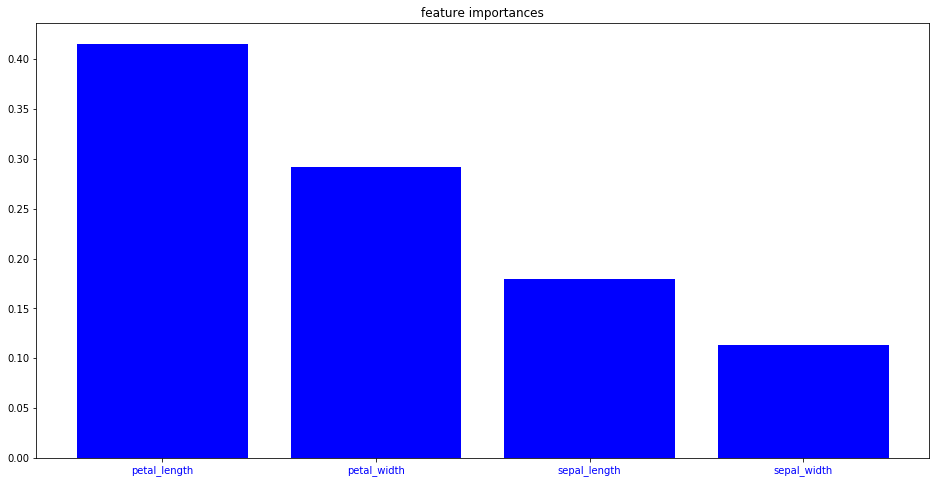

In [12]:
iris = load_iris()
y = iris['target']
X = iris['data']
xgb_model = xgb.XGBClassifier().fit(X,y)

print('特征排序：')
feature_names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for index in indices:
    print("特征 %s 重要度为 %f" %(feature_names[index], feature_importances[index]))

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title("feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], color='b')

### 并行训练加速

In [14]:
import os

if __name__ == "__main__":
    try:
        from multiprocessing import set_start_method
    except ImportError:
        raise ImportError("Unable to import multiprocessing.set_start_method."
                          " This example only runs on Python 3.4")
    #set_start_method("forkserver")

    import numpy as np
    from sklearn.model_selection import GridSearchCV
    from sklearn.datasets import load_boston
    import xgboost as xgb

    rng = np.random.RandomState(31337)

    print("Parallel Parameter optimization")
    boston = load_boston()

    os.environ["OMP_NUM_THREADS"] = "2"  # or to whatever you want
    y = boston['target']
    X = boston['data']
    xgb_model = xgb.XGBRegressor()
    clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                   'n_estimators': [50, 100, 200]}, verbose=1,
                       n_jobs=2)
    clf.fit(X, y)
    print(clf.best_score_)
    print(clf.best_params_)

Parallel Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  27 | elapsed:    2.2s remaining:    0.3s


0.6001029721598573
{'max_depth': 4, 'n_estimators': 100}


[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed:    2.4s finished
